In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import xgcm

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 12

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(10)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.101:45830 Dashboard: http://10.148.1.101:8787/status,Cluster Workers: 8 Cores: 32 Memory: 400.00 GB


In [16]:
## open files, nc files  ##
ncdata_dir = '/home1/scratch/xyu/mit_nc_new/'

# number of fies to load for each face (1 file = 60 days)
Nf = 1
face_60 = [1]

v_u = 'SSU'
v_v = 'SSV'
v_eta = 'Eta'


In [18]:
## Here we do DFT on u+iv ##

for face in face_60:
    
    # SSU #
    filenames_u = sorted(glob(ncdata_dir+v_u+'_f%02d_t*.nc' %(face)))
    filenames_u = filenames_u[:Nf]
    ds_u = xr.open_mfdataset(filenames_u, chunks={'i_g':10, 'j':432}, concat_dim='time', compat='equals')
    chunks={'time': len(ds_u['time'])}
    ds_u = ds_u.chunk(chunks)    


    # SSV #
    filenames_v = sorted(glob(ncdata_dir+v_v+'_f%02d_t*.nc' %(face)))
    filenames_v = filenames_v[:Nf]    
    ds_v = xr.open_mfdataset(filenames_v, chunks={'i':10, 'j_g':432}, concat_dim='time', compat='equals')
    chunks={'time': len(ds_v['time'])}
    ds_v = ds_v.chunk(chunks)   
    
    # Eta#
    filenames_Eta = sorted(glob(ncdata_dir+v_eta+'_f%02d_t*.nc' %(face)))
    filenames_Eta = filenames_Eta[:Nf]        
    ds_Eta = xr.open_mfdataset(filenames_Eta, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
    chunks={'time': len(ds_Eta['time'])}
    ds_Eta = ds_Eta.chunk(chunks)   
    
    # grid file
    grid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
    grid = grid.isel(face=face_60)

In [19]:
# Merge into one xarray dataset #
ds = xr.merge([ds_u,ds_v,ds_Eta,grid])
print(ds)

<xarray.Dataset>
Dimensions:  (face: 1, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 1440)
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
    dtime    (time) datetime64[ns] dask.array<shape=(1440,), chunksize=(1440,)>
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (face, i, j) float32 ...
    YC       (face, i, j) float32 ...
    XG       (face, i_g, j_g) float32 ...
    YG       (face, i_g, j_g) float32 ...
    rA       (face, i, j) float32 ...
    dxG      (face, i, j_g) float32 ...
    dyG      (face, j, i_g) float32 ...
    Depth    (face, i, j) float32 ...
    rAz      (face, i_g, j_g) float32 ...
    dxC      (face, j, i_g) fl

In [20]:
E_dir = '/home1/scratch/xyu/momentum/'
face_1 = 1 # some key faces

---


# 1. Time derivative of SSU ($G_u$)

A central difference is applied to compute du/dt.

In [21]:
Nt = 20
T = np.arange(0, Nt-1)

In [22]:
for t in T:
        
    d_SSU_dt_time = (ds['SSU'].isel(time=t+2) - ds['SSU'].isel(time=t))/2/3600    
    d_SSU_dt_time = np.real(d_SSU_dt_time).rename('d_SSU_dt_time')
    file_E = E_dir+'d_SSU_dt_time_f%02d_t%04d.nc'% (face_1,t+1)                                                                                                      
    d_SSU_dt_time.to_netcdf(file_E, mode='w')  
    print('time %d done'%t )
    

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 1.33 MB detected in task graph: 
  ("('__array_wrap__-570ef4ae554add25b0e73bfecb4c6fd ... 30dd>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


time 0 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


time 1 done


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x2aaaf282fd68>>
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils_perf.py", line 178, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt
Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x2aaaf282fd68>>
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils_perf.py", line 178, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt


KeyboardInterrupt: 

_______

# 2. Coriolis terms ($G_u^{fv}$)

Next we create a `Grid` object from the dataset.
We need to tell xgcm that the `X` and `Y` axes are periodic.
(The other axes will be assumed to be non-periodic.)

In [23]:
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   j (4320) --> left
  * left     j_g (4320) --> center
X Axis (periodic):
  * center   i (4320) --> left
  * left     i_g (4320) --> center

In [24]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_j = grid.interp(f,'Y').load()

In [26]:
nfft = 24  # 24hours * 60 = 60 days 
T = np.arange(1, 120, int(nfft))
print(T)

[ 1 25 49 73 97]


In [28]:
face_1=0

In [ ]:
for t in T:

    dxgSSV_j = grid.interp(ds.dxG.isel(face=face_1) * ds['SSV'].isel(time=slice(t,t+nfft)),'Y')
    dxgSSV_ji = grid.interp(dxgSSV_j,'X')    
    zeta_3 = (grid.diff(ds.dyC.isel(face=face_1) * ds['SSV'].isel(time=slice(t,t+nfft)),'X') - grid.diff(ds.dxC.isel(face=face_1) * ds['SSU'].isel(time=slice(t,t+nfft)),'Y'))/ds.rAz.isel(face=face_1)    
    Coriolis_u = (f_j.isel(face=face_1) + grid.interp(zeta_3,'Y')) * dxgSSV_ji /ds.dxC.isel(face=face_1)    
    Coriolis_u = np.real(Coriolis_u).rename('Coriolis_u')
    file_E = E_dir+'Coriolis_u_f%02d_t%04d.nc'% (face_1,t)                                                                                                          
    Coriolis_u.to_netcdf(file_E, mode='w')  
    print('time %d done'%t )

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


# 6. Residuals

In [37]:
N_open = 120
E_dir = '/home1/scratch/xyu/mit_nc/'

In [39]:
filenames_1 = sorted(glob(E_dir+'Coriolis_u_f01_t*.nc'))
filenames_1 = filenames_1[1:N_open]
%time ds_1 = xr.open_mfdataset(filenames_1, concat_dim='time', compat='equals', decode_cf=False)

filenames_2 = sorted(glob(E_dir+'d_SSU_dt_time_f01_t*.nc'))
filenames_2 = filenames_2[1:N_open]
%time ds_2 = xr.open_mfdataset(filenames_2, concat_dim='time', compat='equals', decode_cf=False)

filenames_3 = sorted(glob(E_dir+'dB_dx_f01_t*.nc'))
filenames_3 = filenames_3[1:N_open]
%time ds_3 = xr.open_mfdataset(filenames_3, concat_dim='time', compat='equals', decode_cf=False)

CPU times: user 980 ms, sys: 304 ms, total: 1.28 s
Wall time: 1.3 s
CPU times: user 920 ms, sys: 252 ms, total: 1.17 s
Wall time: 1.2 s
CPU times: user 1.3 s, sys: 444 ms, total: 1.75 s
Wall time: 12 s


In [40]:
%time ds = xr.merge([ds_1,ds_2,ds_3])
print(ds)

CPU times: user 31.8 s, sys: 1.81 s, total: 33.6 s
Wall time: 1min 48s
<xarray.Dataset>
Dimensions:        (i_g: 4320, j: 4320, time: 119)
Coordinates:
  * j              (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * i_g            (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Dimensions without coordinates: time
Data variables:
    face           (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    dyG            (time, j, i_g) float32 dask.array<shape=(119, 4320, 4320), chunksize=(1, 4320, 4320)>
    dxC            (time, j, i_g) float32 dask.array<shape=(119, 4320, 4320), chunksize=(1, 4320, 4320)>
    rAw            (time, j, i_g) float32 dask.array<shape=(119, 4320, 4320), chunksize=(1, 4320, 4320)>
    Coriolis_u     (time, j, i_g) float32 dask.array<shape=(119, 4320, 4320), chunksize=(1, 4320, 4320)>
    d_SSU_dt_time  (time, j, i_g) float32 dask.array<shape=(119, 4320, 4320), chunksize=(1, 4320, 4320)>
    dB_dx          (time, j, i_

In [41]:
residuals_u_face1 = (ds['d_SSU_dt_time'] - ds['Coriolis_u'] + ds['dB_dx']).load()
print(residuals_u_face1)

<xarray.DataArray (time: 119, j: 4320, i_g: 4320)>
array([[[-4.474729e-05, -4.468339e-06, ..., -5.822873e-06, -5.780633e-06],
        [-2.582579e-05, -1.524413e-07, ..., -9.770432e-06, -9.242965e-06],
        ...,
        [ 6.067454e-06,  4.178451e-06, ...,  2.897446e-06,  5.194416e-06],
        [-2.460253e-05, -1.319541e-05, ..., -3.855219e-06, -8.859575e-06]],

       [[-3.028262e-05,  1.597712e-06, ..., -3.093354e-06,  3.373754e-06],
        [-1.808310e-05,  4.017196e-06, ..., -1.798203e-06,  4.609339e-06],
        ...,
        [-2.739991e-06, -1.056930e-05, ...,  1.614298e-06,  2.599428e-06],
        [-1.163991e-05, -7.477613e-06, ..., -2.128599e-06, -7.070470e-06]],

       ...,

       [[ 1.203326e-05,  2.309136e-05, ...,  9.288104e-06,  1.951275e-05],
        [ 8.433424e-07,  7.998826e-06, ...,  5.531551e-06,  1.562556e-05],
        ...,
        [-7.315416e-06, -1.126083e-06, ..., -9.318879e-06, -1.285273e-06],
        [-3.015575e-07, -5.415177e-07, ..., -6.657939e-06, -7.508534

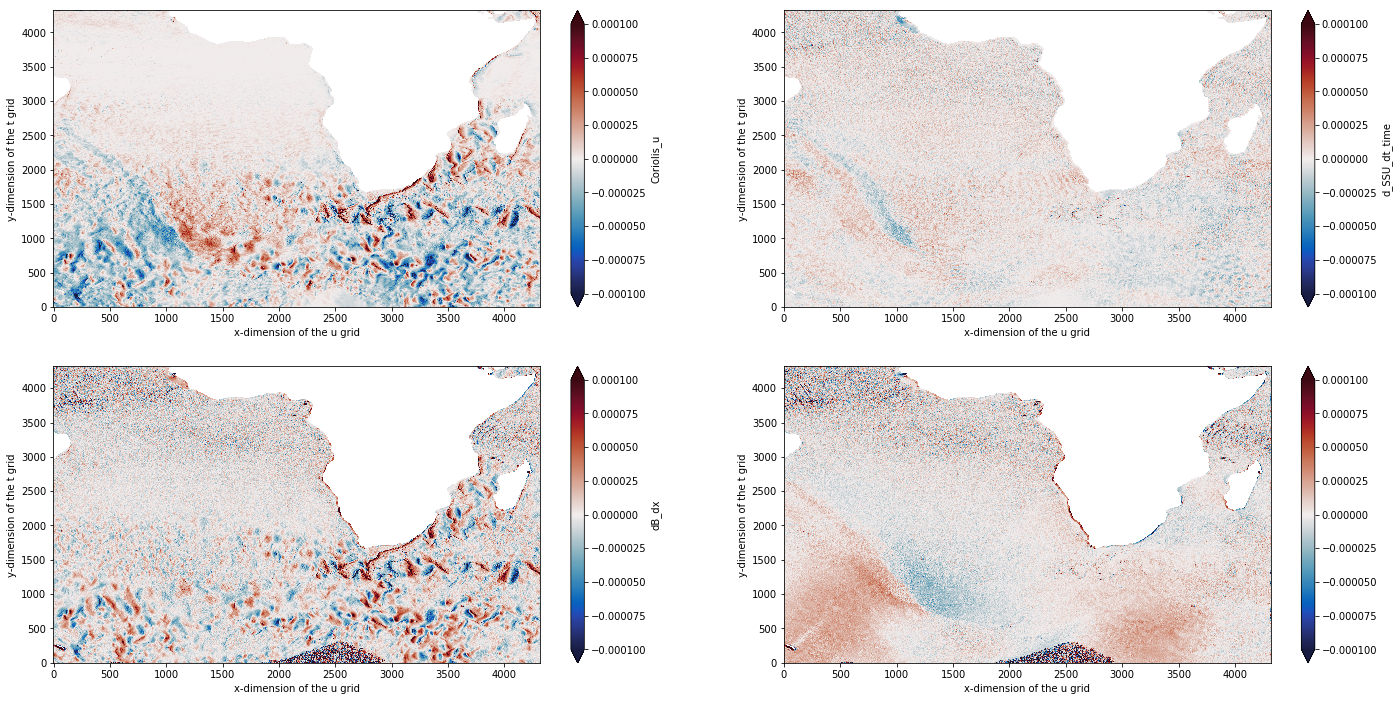

In [49]:
fig = plt.figure(figsize = (24,12))

plt.subplot(221)
ds['Coriolis_u'].isel(time=70).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(222)
ds['d_SSU_dt_time'].isel(time=70).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(223)
ds['dB_dx'].isel(time=70).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(224)
residuals_u_face1.isel(time=70).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)


In [42]:
residuals_u_face1_std = residuals_u_face1.isel(j=slice(500,1000)).std(['i_g','j']).load()
Coriolis_u_std = ds['Coriolis_u'].isel(j=slice(500,1000)).std(['i_g','j']).load()
dB_dx_std = ds['dB_dx'].isel(j=slice(500,1000)).std(['i_g','j']).load()
d_SSU_dt_time_std = ds['d_SSU_dt_time'].isel(j=slice(500,1000)).std(['i_g','j']).load()

In [44]:
residuals_u_face1_mean = residuals_u_face1.isel(j=slice(500,1000)).mean(['i_g','j']).load()
Coriolis_u_mean = ds['Coriolis_u'].isel(j=slice(500,1000)).mean(['i_g','j']).load()
dB_dx_mean = ds['dB_dx'].isel(j=slice(500,1000)).mean(['i_g','j']).load()
d_SSU_dt_time_mean = ds['d_SSU_dt_time'].isel(j=slice(500,1000)).mean(['i_g','j']).load()

In [45]:
residuals_u_face1_rms = (residuals_u_face1.isel(j=slice(500,1000))**2).mean(['i_g','j']).load()
Coriolis_u_rms = (ds['Coriolis_u'].isel(j=slice(500,1000))**2).mean(['i_g','j']).load()
dB_dx_rms = (ds['dB_dx'].isel(j=slice(500,1000))**2).mean(['i_g','j']).load()
d_SSU_dt_time_rms = (ds['d_SSU_dt_time'].isel(j=slice(500,1000))**2).mean(['i_g','j']).load()

(0, 3.0000000000000004e-05)

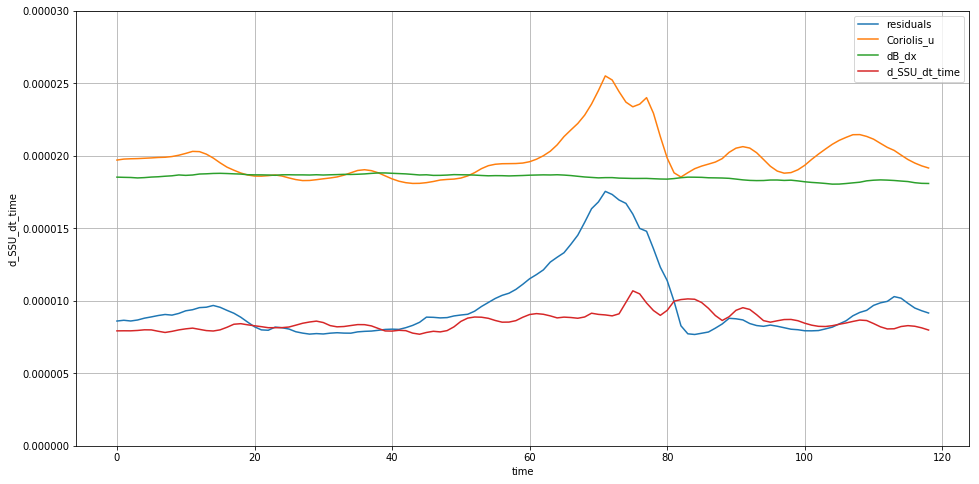

In [43]:
fig, ax = plt.subplots(figsize=(16,8))
labels = ['residuals', 'Coriolis_u','dB_dx','d_SSU_dt_time']

residuals_u_face1_std.plot(ax=ax, label=labels[0])
Coriolis_u_std.plot(ax=ax, label=labels[1])
dB_dx_std.plot(ax=ax, label=labels[2])
d_SSU_dt_time_std.plot(ax=ax, label=labels[3])
ax.legend(); ax.grid()
#ax.set_xlim([8*1e-8,2*1e-4])
ax.set_ylim([0,3*1e-5])

(0, 1e-09)

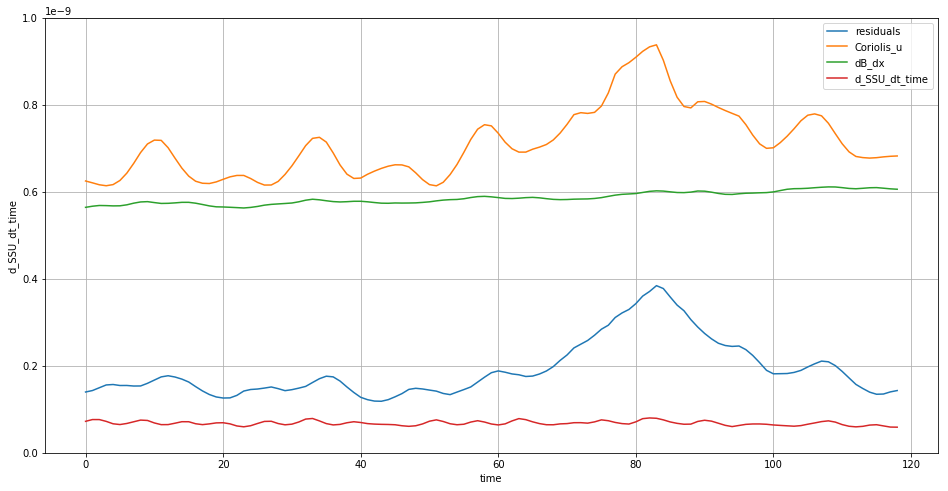

In [46]:
fig, ax = plt.subplots(figsize=(16,8))
labels = ['residuals', 'Coriolis_u','dB_dx','d_SSU_dt_time']

residuals_u_face1_rms.plot(ax=ax, label=labels[0])
Coriolis_u_rms.plot(ax=ax, label=labels[1])
dB_dx_rms.plot(ax=ax, label=labels[2])
d_SSU_dt_time_rms.plot(ax=ax, label=labels[3])
ax.legend(); ax.grid()
#ax.set_xlim([8*1e-8,2*1e-4])
ax.set_ylim([0,1*1e-9])

(-1e-05, 1e-05)

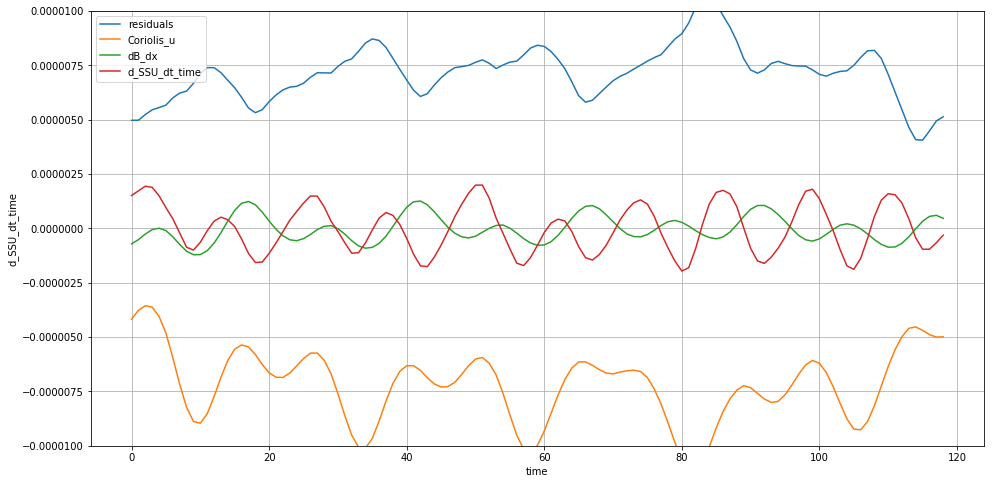

In [47]:
fig, ax = plt.subplots(figsize=(16,8))
labels = ['residuals', 'Coriolis_u','dB_dx','d_SSU_dt_time']

residuals_u_face1_mean.plot(ax=ax, label=labels[0])
Coriolis_u_mean.plot(ax=ax, label=labels[1])
dB_dx_mean.plot(ax=ax, label=labels[2])
d_SSU_dt_time_mean.plot(ax=ax, label=labels[3])
ax.legend(); ax.grid()
#ax.set_xlim([8*1e-8,2*1e-4])
ax.set_ylim([-1*1e-5,1*1e-5])

In [51]:
cluster.scheduler.close()

<Future finished result=None>